# CW1 - Multimodal IMDB Analysis with Keras

## Introduction

In this assignment you will be provided a dataset containing a selection of films together with their posters in JPEG image format and their overviews in text format from the Internet Movie Database.

![Example](https://i.ibb.co/J3trT62/Screenshot-2024-09-22-214753.png)

You will be analysing this dataset by implementing and training two models: a **CNN** and an **LSTM**.

The CNN must classify film posters by the genre. Independently, the LSTM must classify film overviews by the genre. Finally, you will evaluate and critically comment your results in a short report. (Which of the two models was better at classifying films?)

## Structure of the assignment

This assignment is broken up into sections and you need to complete each section successively. The sections are the following:

1. Data Processing

  1.a. Image processing of the posters

  1.b. Natural language processing of the overviews

2. Definition of the models

  2.a. CNN for the posters

  2.b. LSTM for the overviews

3. Training of the models
4. Evaluation of the models

In addition to this coding exercise, you must write a **2-3 pages** report analysing and critically evaluating your model's results. Marks for the report will be awarded for depth of analysis and critical thinking skills. You should consider how well your model performs and WHY it does that—give specific examples and comment on their importance.

In [28]:
# Enter your module imports here, some modules are already provided

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import os
import pathlib
import pandas as pd
from sklearn import model_selection
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from keras.metrics import Precision, Recall
from tensorflow.keras.layers import Input, Conv2D, Dropout, MaxPooling2D, Flatten, Dense

In [29]:
# CodeGrade Tag Init1
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 1. Data Processing

Warning: running the following cell can take some time.


In [30]:
# CodeGrade Tag Init2
# Do not edit, remove, or copy this cell

# This code will copy the images from your google drive into the colab file
# storage. Make sure the dataset is unzipped in your drive folder.
! mkdir /tmp/Multimodal_IMDB_dataset
! rsync -ah --info=progress2 /content/drive/MyDrive/Multimodal_IMDB_dataset/Images /tmp/Multimodal_IMDB_dataset/


        192.14M 100%  672.38kB/s    0:04:39 (xfr#7916, to-chk=0/7917)
mkdir: cannot create directory ‘/tmp/Multimodal_IMDB_dataset’: File exists
              0   0%    0.00kB/s    0:00:00 (xfr#0, to-chk=0/7917)   


In [31]:
# CodeGrade Tag Init3
# Do not edit, remove, or copy this cell

# Load the csv with the sample IDs and genres
csv_loc = "/content/drive/MyDrive/Multimodal_IMDB_dataset/IMDB_overview_genres.csv"
dataset = pd.read_csv(csv_loc)

# Split the dataset into training and testing
data_train, data_test = model_selection.train_test_split(dataset, test_size=0.2)

# Convert the labels to arrays
labels_train = np.array(data_train.drop(['Id', 'Genre', 'Overview'],axis=1)).astype('float32')
labels_test = np.array(data_test.drop(['Id', 'Genre', 'Overview'],axis=1)).astype('float32')

# List of the genre names
genres = np.array(data_train.drop(['Id', 'Genre', 'Overview'],axis=1).columns)

# List of overviews
overviews_train = np.array(data_train['Overview'])
overviews_test = np.array(data_test['Overview'])

# Build the file locations for the images
img_loc = "/content/drive/MyDrive/Multimodal_IMDB_dataset/Images"

img_locs_train = np.array([[img_loc + '/' + id + '.jpg' for id in data_train['Id']]])
img_locs_test = [[img_loc + '/' + id + '.jpg' for id in data_test['Id']]]

# This function is provided to read in the image files from the folder
def parse_image(filename, label):
  image = tf.io.read_file(filename)
  image = tf.io.decode_jpeg(image)
  return image, label


### 1.a. Image processing of the posters

In [32]:
# CodeGrade Tag Init4
# Do not edit, remove, or copy this cell

# Create the initial datasets of film posters
list_posters_train_ds = tf.data.Dataset.from_tensor_slices((img_locs_train[0], labels_train))
list_posters_valid_ds = tf.data.Dataset.from_tensor_slices((img_locs_test[0], labels_test))

* Create a function called ```img_process``` that converts the images to float32 datatype and resizes them to 64x64 pixels

In [33]:
# CodeGrade Tag Ex1a-i
### Create a function called img_process that converts the images to
### float32 datatype and resizes them to 64x64 pixels

def img_process(image, label):
  """Processes an image by resizing it and converting it to float32.

  Args:
    image: A TensorFlow tensor representing the image.
    label: The image label.

  Returns:
    A tuple containing the processed image and label.
  """
  image = tf.image.resize(image, [64, 64])  # Resize to 64x64 pixels
  image = tf.cast(image, dtype=tf.float32)  # Convert to float32

  return image, label


* **Using the ``tf.data`` API, load in the training and validation data for the posters. Be mindful of efficient data processing good practice to minimise the time it takes to load the data.**

In [34]:
# CodeGrade Tag Ex1a-ii
### Use the parse_image and img_process functions to construct the training and
### validation datasets. You should utilise good practice in optimising the
### dataset loading. Use a batch size of 64.

# Adjust to process data in batches
posters_train_ds = (
    list_posters_train_ds
    .map(parse_image, num_parallel_calls=tf.data.AUTOTUNE)  # Apply parse_image in parallel
    .batch(64)  # Batch the data
    .map(img_process, num_parallel_calls=tf.data.AUTOTUNE)  # Vectorized img_process
    .cache()  # Cache data
    .prefetch(tf.data.AUTOTUNE)  # Optimize prefetching
)

posters_valid_ds = (
    list_posters_valid_ds
    .map(parse_image, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(64)
    .map(img_process, num_parallel_calls=tf.data.AUTOTUNE)
    .cache()
    .prefetch(tf.data.AUTOTUNE)
)


### 1.b. Natural Language processing of the overviews

In [35]:
# CodeGrade Tag Init5
# Do not edit, remove, or copy this cell

# Create the initial datasets of the film overviews
list_overviews_train_ds = tf.data.Dataset.from_tensor_slices((overviews_train, labels_train))
list_overviews_valid_ds = tf.data.Dataset.from_tensor_slices((overviews_test, labels_test))


* **Using the ``tf.data`` API, load in the training and validation data for the overviews.**

In [36]:
# CodeGrade Tag Ex1b-i
### Construct the training and validation datasets. Use a batch size of 64.

overviews_train_ds = list_overviews_train_ds.batch(64).prefetch(tf.data.AUTOTUNE)  # Batch size is 64

# Create the validation dataset and set a batch size of 64
overviews_valid_ds = list_overviews_valid_ds.batch(64).prefetch(tf.data.AUTOTUNE)  # Batch size is 64




* Build the vocabulary of the model by calling the ``encoder.adapt()`` method on the film overviews train data.

In [37]:
# CodeGrade Tag Ex1b-ii
### Build the vocabulary of the model by calling the encoder.adapt() method on
### the film overviews train data.

VOCAB_SIZE = 10000

encoder = tf.keras.layers.TextVectorization(max_tokens=VOCAB_SIZE)

encoder.adapt(overviews_train_ds.map(lambda text, label: text))

* Print the first 200 words of the vocabulary you obtained.

In [38]:
# CodeGrade Tag Ex1b-iii
### Print the first 200 words of the vocabulary you obtained.

vocab = np.array(encoder.get_vocabulary())
print(vocab[:200])

['' '[UNK]' 'a' 'the' 'to' 'of' 'and' 'in' 'his' 'is' 'an' 'with' 'her'
 'for' 'on' 'he' 'their' 'who' 'by' 'from' 'when' 'as' 'that' 'after'
 'young' 'life' 'they' 'at' 'man' 'two' 'new' 'him' 'are' 'but' 'into'
 'has' 'she' 'up' 'woman' 'love' 'one' 'family' 'out' 'find' 'friends'
 'must' 'be' 'them' 'finds' 'story' 'world' 'it' 'school' 'where' 'about'
 'while' 'have' 'group' 'years' 'girl' 'father' 'home' 'wife' 'war' 'town'
 'lives' 'help' 'three' 'becomes' 'get' 'during' 'all' 'back' 'son' 'city'
 'boy' 'only' 'himself' 'which' 'between' 'gets' 'time' 'former' 'high'
 'york' 'murder' 'against' 'team' 'american' 'own' 'small' 'other' 'takes'
 'friend' 'college' 'being' 'mother' 'police' 'down' 'daughter' 'before'
 'its' 'tries' 'this' 'can' 'was' 'order' 'falls' 'become' 'death' 'will'
 'take' 'agent' 'together' 'save' 'old' 'not' 'goes' 'set' 'relationship'
 'way' 'through' 'over' 'first' 'husband' 'people' 'killer' 'off'
 'returns' 'more' 'living' 'couple' 'what' 'meets' 'go' 'f

# 2. Definition of the models

### 2.a. CNN

**Using the Keras Functional API, create a convolutional neural network with the architecture shown in the model summary below.**

**A few important points to consider:**

* Call the convolutional layers and the first dense layer should have ReLU activation functions. The output layer should have a Sigmoid activation function.
* Pay attention to the output shapes and the number of partmeters for each layer, as these give indications as to the correct settings for the number of filters, kernel size, stride length and padding.
* Use the layer names provided in the summary in your model.
* For the dropout layers, use a dropout rate of 0.2 after the convolutional layers and 0.5 after the dense layers.


```
# Model Summary

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
=================================================================
 Input (InputLayer)          [(None, 64, 64, 3)]       0         
                                                                 
 Conv0 (Conv2D)              (None, 32, 32, 16)        448       
                                                                 
 Drop1 (Dropout)             (None, 32, 32, 16)        0         
                                                                 
 Conv1 (Conv2D)              (None, 32, 32, 32)        4640      
                                                                 
 Conv2 (Conv2D)              (None, 32, 32, 32)        9248      
                                                                 
 Drop2 (Dropout)             (None, 32, 32, 32)        0         
                                                                 
 Pool1 (MaxPooling2D)        (None, 16, 16, 32)        0         
                                                                 
 Conv3 (Conv2D)              (None, 16, 16, 64)        18496     
                                                                 
 Conv4 (Conv2D)              (None, 16, 16, 64)        36928     
                                                                 
 Drop3 (Dropout)             (None, 16, 16, 64)        0         
                                                                 
 Pool2 (MaxPooling2D)        (None, 8, 8, 64)          0         
                                                                 
 Conv5 (Conv2D)              (None, 8, 8, 128)         73856     
                                                                 
 Conv6 (Conv2D)              (None, 8, 8, 128)         147584    
                                                                 
 Drop4 (Dropout)             (None, 8, 8, 128)         0         
                                                                 
 Pool3 (MaxPooling2D)        (None, 4, 4, 128)         0         
                                                                 
 Flat (Flatten)              (None, 2048)              0         
                                                                 
 FC1 (Dense)                 (None, 1024)              2098176   
                                                                 
 Drop5 (Dropout)             (None, 1024)              0         
                                                                 
 FC2 (Dense)                 (None, 1024)              1049600   
                                                                 
 Drop6 (Dropout)             (None, 1024)              0         
                                                                 
 Output (Dense)              (None, 25)                25625     
                                                                 
=================================================================
Total params: 3464601 (13.22 MB)
Trainable params: 3464601 (13.22 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


```



In [39]:
# CodeGrade Tag Ex2a-i
### Define the model using the Keras Functional API. Use the summary above as a
### guide for the model parameters. You will need to define the filters/units of
### the layers correctly, as well as the kernel size, stride length and padding
### of the convolutional layers.

def build_cnn_model():
    """Builds the CNN model using the Keras Functional API.

    Returns:
        The compiled CNN model.
    """
    input_tensor = Input(shape=(64, 64, 3), name='Input')

    # Convolutional layers
    x = Conv2D(16, (3, 3), activation='relu', strides=2, padding='same', name='Conv0')(input_tensor)
    x = Dropout(0.2, name='Drop1')(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same', name='Conv1')(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same', name='Conv2')(x)
    x = Dropout(0.2, name='Drop2')(x)
    x = MaxPooling2D((2, 2), name='Pool1')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='Conv3')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='Conv4')(x)
    x = Dropout(0.2, name='Drop3')(x)
    x = MaxPooling2D((2, 2), name='Pool2')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='Conv5')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='Conv6')(x)
    x = Dropout(0.2, name='Drop4')(x)
    x = MaxPooling2D((2, 2), name='Pool3')(x)

    # Flatten and dense layers
    x = Flatten(name='Flat')(x)
    x = Dense(1024, activation='relu', name='FC1')(x)
    x = Dropout(0.5, name='Drop5')(x)
    x = Dense(1024, activation='relu', name='FC2')(x)
    x = Dropout(0.5, name='Drop6')(x)

    # Output layer
    output_tensor = Dense(25, activation='sigmoid', name='Output')(x)

    # Create the model
    model = Model(inputs=input_tensor, outputs=output_tensor, name='model')
    return model

cnn_model = build_cnn_model()


* Print the model summary and confirm it has the same architecture as the one provided.

In [40]:
# CodeGrade Tag Ex2a-ii
### Print the model summary and confirm it has the same architecture as the one
### provided.

cnn_model.summary()

Model: "model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Input (InputLayer)                   │ (None, 64, 64, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv0 (Conv2D)                       │ (None, 32, 32, 16)          │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Drop1 (Dropout)                      │ (None, 32, 32, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv1 (Conv2D)                       │ (None, 32, 32, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv2 (Conv2D)                       │ (None, 32, 32, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Drop2 (Dropout)                      │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Pool1 (MaxPooling2D)                 │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv3 (Conv2D)                       │ (None, 16, 16, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv4 (Conv2D)                       │ (None, 16, 16, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Drop3 (Dropout)                      │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Pool2 (MaxPooling2D)                 │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv5 (Conv2D)                       │ (None, 8, 8, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv6 (Conv2D)                       │ (None, 8, 8, 128)           │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Drop4 (Dropout)                      │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Pool3 (MaxPooling2D)                 │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Flat (Flatten)                       │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ FC1 (Dense)                          │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Drop5 (Dropout)                      │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ FC2 (Dense)                          │ (None, 1024)                │       1,049,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Drop6 (Dropout)                      │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Output (Dense)                       │ (None, 25)                  │          25,625 │
└──────────────────────────────────────┴─────────────────────────────┴──────────────

 Total params: 3,464,601 (13.22 MB)

 Trainable params: 3,464,601 (13.22 MB)

 Non-trainable params: 0 (0.00 B)

Model: "model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Input (InputLayer)                   │ (None, 64, 64, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv0 (Conv2D)                       │ (None, 32, 32, 16)          │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Drop1 (Dropout)                      │ (None, 32, 32, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv1 (Conv2D)                       │ (None, 32, 32, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv2 (Conv2D)                       │ (None, 32, 32, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Drop2 (Dropout)                      │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Pool1 (MaxPooling2D)                 │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv3 (Conv2D)                       │ (None, 16, 16, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv4 (Conv2D)                       │ (None, 16, 16, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Drop3 (Dropout)                      │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Pool2 (MaxPooling2D)                 │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv5 (Conv2D)                       │ (None, 8, 8, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv6 (Conv2D)                       │ (None, 8, 8, 128)           │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Drop4 (Dropout)                      │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Pool3 (MaxPooling2D)                 │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Flat (Flatten)                       │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ FC1 (Dense)                          │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Drop5 (Dropout)                      │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ FC2 (Dense)                          │ (None, 1024)                │       1,049,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Drop6 (Dropout)                      │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Output (Dense)                       │ (None, 25)                  │          25,625 │
└──────────────────────────────────────┴─────────────────────────────┴──────────────

 Total params: 3,464,601 (13.22 MB)

 Trainable params: 3,464,601 (13.22 MB)

 Non-trainable params: 0 (0.00 B)

* **Compile the model using the Adam Optimizer with a learning rate of ```1e-4``` and ```binary crossentropy``` loss function. For the metrics, use the ``Precision`` and ``Recall`` functions.**

In [41]:
# CodeGrade Tag Ex2a-iii
### Compile the model using the Adam Optimizer with a learning rate of 1e-4 and
### binary crossentropy loss function. For the metrics, use the Precision and
### Recall functions.

cnn_model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=[Precision(), Recall()]
)

### 2.b. LSTM model

* Set up the embedding layer by using ```tf.keras.layers.Embedding```. The ```input_dim``` is the length of the vocab, and the ```output_dim``` must be **265**. You should also set ```mask_zero=True```.

In [42]:
# CodeGrade Tag Ex2b-i
### Set up the embedding layer. The input_dim is the length of the vocab, and
### the output_dim must be 256. You should also set mask_zero=True.

embedder = tf.keras.layers.Embedding(input_dim=VOCAB_SIZE, output_dim=256, mask_zero=True)

* Use ```tf.keras.Sequential``` to build a keras sequential model, with the following layers:



  1.   encoder
  2.   embedder
  3.   biLSTM layer with 256 units, dropout 0.5, recurrent dropout 0.2 (make sure to use the right ```return_sequences``` parametre to be able to stack this layer with the following BiLSTM)
  4.   biLSTM layer with 128 units, dropout 0.5, recurrent dropout 0.2
  5.   dense layer with 128 units and relu activation function
  6.   dropout with rate 0.8
  7.   dense output layer with 25 units and sigmoid activation function



In [43]:
# CodeGrade Tag Ex2b-ii
### Build a keras sequential model, with the layers provided above.

lstm_model = tf.keras.Sequential([
    encoder,
    embedder,
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256, dropout=0.5, recurrent_dropout=0.2, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, dropout=0.5, recurrent_dropout=0.2)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.8),
    tf.keras.layers.Dense(25, activation='sigmoid')
])

lstm_model.build((None,))

* Print the model summary and confirm is has the same architecture as the outline provided above.

In [44]:
# CodeGrade Tag Ex2b-iii
### Print the model summary and confirm is has the same architecture as the
### outline provided above.
lstm_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ text_vectorization                   │ (None, None)                │               0 │
│ (TextVectorization)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding (Embedding)                │ (None, None, 256)           │       2,560,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, None, 512)           │       1,050,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 256)                 │         656,384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 25)                  │           3,225 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,303,129 (16.42 MB)

 Trainable params: 4,303,129 (16.42 MB)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ text_vectorization_1                 │ (None, None)                │               0 │
│ (TextVectorization)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_1 (Embedding)              │ (None, None, 256)           │       2,560,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_2 (Bidirectional)      │ (None, None, 512)           │       1,050,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_3 (Bidirectional)      │ (None, 256)                 │         656,384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 25)                  │           3,225 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,303,129 (16.42 MB)

 Trainable params: 4,303,129 (16.42 MB)

 Non-trainable params: 0 (0.00 B)

* Compile the model with binary crossentropy loss and the adam optimizer. For the metrics, use the Precision and Recall functions.

In [45]:
# CodeGrade Tag Ex2b-iv
### Compile the model with binary crossentropy loss, the adam optimizer, with
### the precision and recall metrics

### Compile the model with binary crossentropy loss, the adam optimizer, with
### the precision and recall metrics

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall

# Compile the LSTM model with corrected metrics
lstm_model.compile(
    optimizer=Adam(learning_rate=1e-4),  # Optimizer with a specific learning rate
    loss='binary_crossentropy',  # Suitable for binary classification
    metrics=[
        Precision(name='precision'),  # Precision metric
        Recall(name='recall')         # Recall metric
    ]
)


# 3. Training of the models

* **For each model, create a Checkpoint Callback that saves the weights of the best performing epoch, based on the validation loss.**

In [46]:
# CodeGrade Tag Ex3a-i
### Create two ModelCheckpoint callbacks to store the bext weights from each
### model, both based on the validation loss.

checkpoint_cnn_filepath = '/content/checkpoint_cnn.weights.h5'
checkpoint_lstm_filepath = '/content/checkpoint_lstm.weights.h5'

from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint_cnn_callback = ModelCheckpoint(
    filepath=checkpoint_cnn_filepath,
    monitor='val_loss',
    save_best_only=True,
    mode='min',
    verbose=1,
    save_weights_only=True
)

checkpoint_lstm_callback = ModelCheckpoint(
    filepath=checkpoint_lstm_filepath,
    monitor='val_loss',
    save_best_only=True,
    mode='min',
    verbose=1,
    save_weights_only=True
)

* **Create a Learning Rate Scheduler Callback that utilises the provided function to decrease the learning rate during training.**

In [47]:
# CodeGrade Tag Ex3a-ii
### Using the function provided, create a LearningRateScheduler callback, call
### it "lr_callback"

from tensorflow.keras.callbacks import LearningRateScheduler

def scheduler(epoch, lr):
    if epoch < 10:
        return float(lr)
    else:
        return float(lr * tf.math.exp(-0.01))

lr_callback = LearningRateScheduler(scheduler)


### 3.a. CNN training

* **Train the CNN model for 40 epochs, using the callbacks you made previously. Store the losses and metrics to use later.**

In [48]:
# CodeGrade Tag Ex3a-iii
### Train the model for 40 epochs, using the callbacks you have created. Store
### the losses and metrics in a history object.

cnn_history = cnn_model.fit(
    posters_train_ds,
    validation_data=posters_valid_ds,
    epochs=40,
    callbacks=[checkpoint_cnn_callback, lr_callback]
)

Epoch 1/40
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step - loss: 2.3945 - precision: 0.2142 - recall: 0.3280
Epoch 1: val_loss improved from inf to 0.34936, saving model to /content/checkpoint_cnn.weights.h5
80/80 ━━━━━━━━━━━━━━━━━━━━ 38s 322ms/step - loss: 2.3764 - precision: 0.2149 - recall: 0.3275 - val_loss: 0.3494 - val_precision: 0.5620 - val_recall: 0.3059 - learning_rate: 1.0000e-04
Epoch 2/40
77/80 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.3021 - precision: 0.3950 - recall: 0.2452
Epoch 2: val_loss did not improve from 0.34936
80/80 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - loss: 0.3017 - precision: 0.3959 - recall: 0.2452 - val_loss: 0.3524 - val_precision: 0.5642 - val_recall: 0.3271 - learning_rate: 1.0000e-04
Epoch 3/40
79/80 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2782 - precision: 0.4468 - recall: 0.2395
Epoch 3: val_loss did not improve from 0.34936
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.2781 - precision: 0.4471 - recall: 0.2394 - val_loss: 0.3539 - val_precision: 

* **Train the model for 20 epochs** (this may take several minutes)**, using the callbacks you made previously. Store the losses and metrics to use later.**

In [49]:
# CodeGrade Tag Ex3b-i
# Train the model for 20 epochs.


# Train the model for 20 epochs
lstm_history = lstm_model.fit(
    overviews_train_ds,
    validation_data=overviews_valid_ds,
    epochs=20,
    callbacks=[checkpoint_lstm_callback, lr_callback]
)

Epoch 1/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step - loss: 0.6674 - precision: 0.1181 - recall: 0.4616
Epoch 1: val_loss improved from inf to 0.38797, saving model to /content/checkpoint_lstm.weights.h5
80/80 ━━━━━━━━━━━━━━━━━━━━ 55s 512ms/step - loss: 0.6668 - precision: 0.1182 - recall: 0.4611 - val_loss: 0.3880 - val_precision: 0.5357 - val_recall: 0.2259 - learning_rate: 1.0000e-04
Epoch 2/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step - loss: 0.4885 - precision: 0.1653 - recall: 0.3345
Epoch 2: val_loss improved from 0.38797 to 0.30640, saving model to /content/checkpoint_lstm.weights.h5
80/80 ━━━━━━━━━━━━━━━━━━━━ 71s 455ms/step - loss: 0.4883 - precision: 0.1654 - recall: 0.3344 - val_loss: 0.3064 - val_precision: 0.4980 - val_recall: 0.4144 - learning_rate: 1.0000e-04
Epoch 3/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step - loss: 0.4280 - precision: 0.2059 - recall: 0.3113
Epoch 3: val_loss improved from 0.30640 to 0.27295, saving model to /content/checkpoint_lstm.weights.h5
80/80 ━━

# 4. Evaluation of the models

### 4.a. CNN Evaluation

* **Create plots using the losses and metrics. In your report, discuss these results and critically evaluate the model performance.**

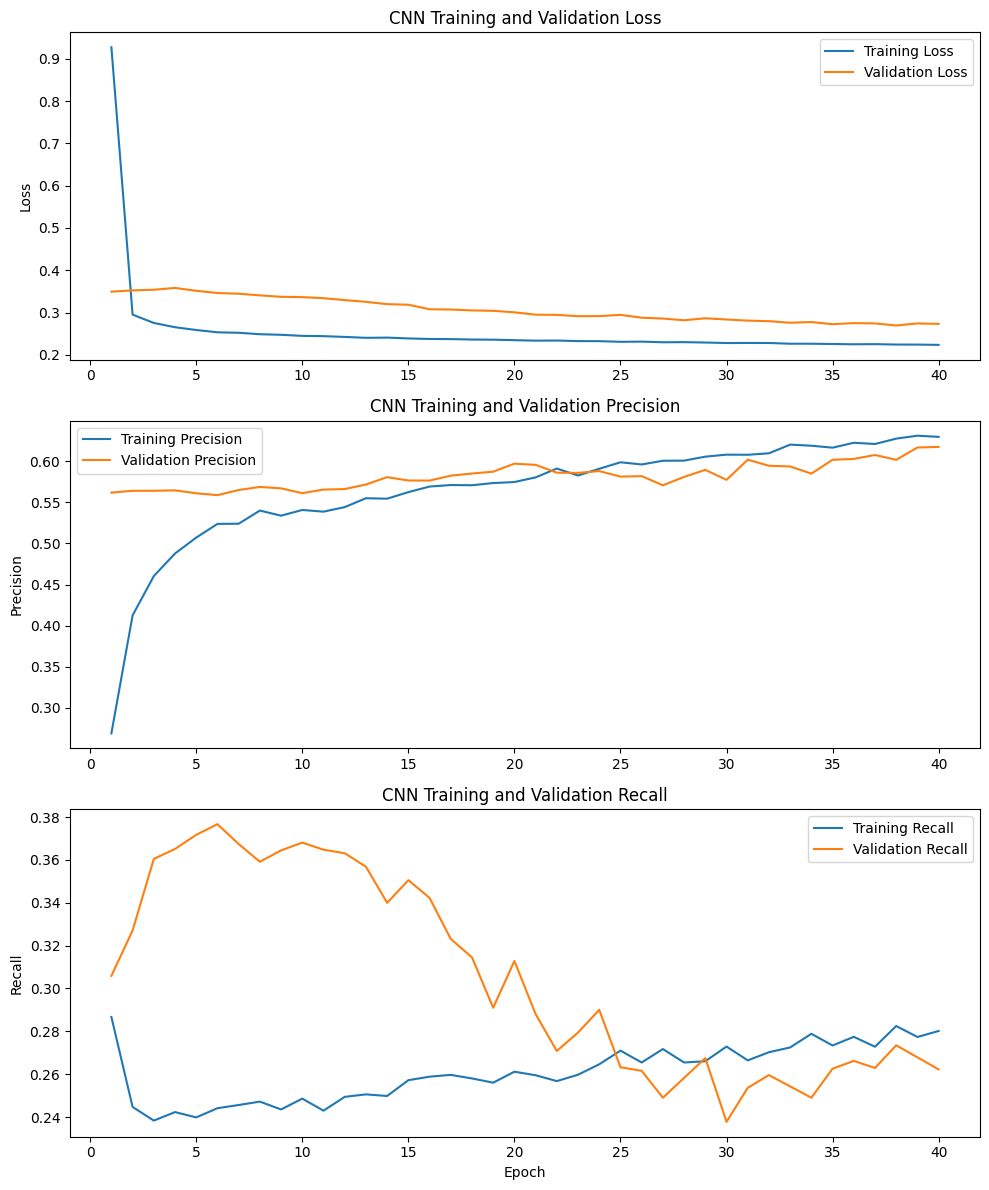

KeyError: 'precision'

In [50]:
# CodeGrade Tag Ex4a-i


import matplotlib.pyplot as plt
import seaborn as sns

# Extract loss and metrics from the training history
train_loss = cnn_history.history['loss']
val_loss = cnn_history.history['val_loss']
train_precision = cnn_history.history['precision']
val_precision = cnn_history.history['val_precision']
train_recall = cnn_history.history['recall']
val_recall = cnn_history.history['val_recall']

# Number of epochs
epochs = range(1, len(train_loss) + 1)

# Create subplots for Loss, Precision, and Recall
fig, axes = plt.subplots(3, 1, figsize=(10, 12))

# --- Loss Plot ---
sns.lineplot(x=epochs, y=train_loss, ax=axes[0], label='Training Loss')
sns.lineplot(x=epochs, y=val_loss, ax=axes[0], label='Validation Loss')
axes[0].set_title('CNN Training and Validation Loss')
axes[0].set_ylabel('Loss')
axes[0].legend()

# --- Precision Plot ---
sns.lineplot(x=epochs, y=train_precision, ax=axes[1], label='Training Precision')
sns.lineplot(x=epochs, y=val_precision, ax=axes[1], label='Validation Precision')
axes[1].set_title('CNN Training and Validation Precision')
axes[1].set_ylabel('Precision')
axes[1].legend()

# --- Recall Plot ---
sns.lineplot(x=epochs, y=train_recall, ax=axes[2], label='Training Recall')
sns.lineplot(x=epochs, y=val_recall, ax=axes[2], label='Validation Recall')
axes[2].set_title('CNN Training and Validation Recall')
axes[2].set_ylabel('Recall')
axes[2].set_xlabel('Epoch')
axes[2].legend()

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

* **Load the best weights from your model checkpoint, and create plots demonstrating the classification performance for all three classes. Include these plots in your report, and critically evaluate on the performance of the model across the classes.**

### 4.b. LSTM Evaluation

* **Create plots using the losses and metrics. In your report, discuss these results and critically evaluate the model performance.**

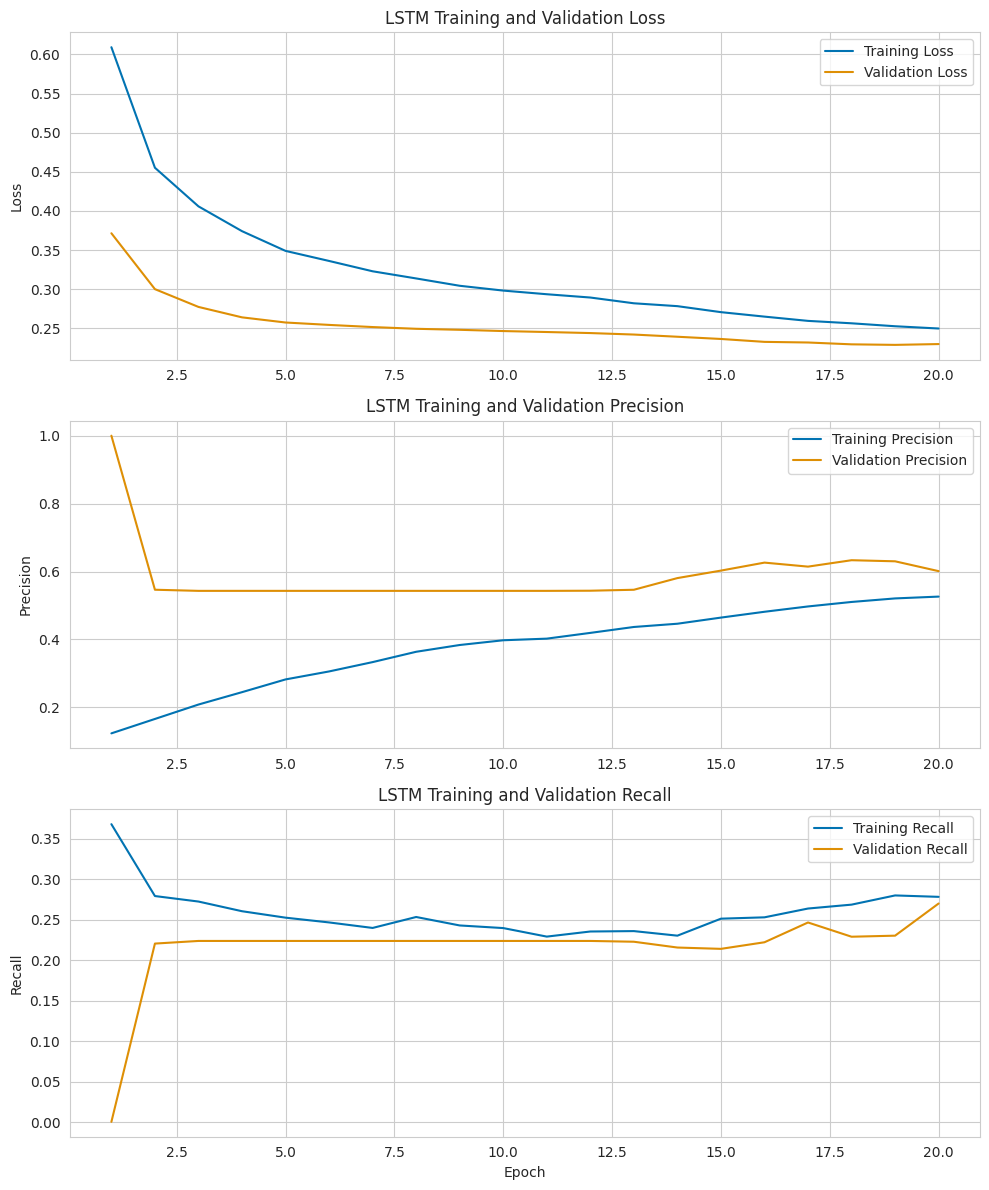

In [51]:
# CodeGrade Tag Ex4b-i


import matplotlib.pyplot as plt
import seaborn as sns

# Set a visually appealing style with a colorblind-friendly palette
sns.set_style("whitegrid")
sns.set_palette("colorblind")

# Extract loss and metrics from the training history
train_loss = lstm_history.history['loss']
val_loss = lstm_history.history['val_loss']
train_precision = lstm_history.history['precision']
val_precision = lstm_history.history['val_precision']
train_recall = lstm_history.history['recall']
val_recall = lstm_history.history['val_recall']

# Number of epochs
epochs = range(1, len(train_loss) + 1)

# Create subplots for Loss, Precision, and Recall
fig, axes = plt.subplots(3, 1, figsize=(10, 12))

# --- Loss Plot ---
sns.lineplot(x=epochs, y=train_loss, ax=axes[0], label='Training Loss')
sns.lineplot(x=epochs, y=val_loss, ax=axes[0], label='Validation Loss')
axes[0].set_title('LSTM Training and Validation Loss')
axes[0].set_ylabel('Loss')
axes[0].legend()

# --- Precision Plot ---
sns.lineplot(x=epochs, y=train_precision, ax=axes[1], label='Training Precision')
sns.lineplot(x=epochs, y=val_precision, ax=axes[1], label='Validation Precision')
axes[1].set_title('LSTM Training and Validation Precision')
axes[1].set_ylabel('Precision')
axes[1].legend()

# --- Recall Plot ---
sns.lineplot(x=epochs, y=train_recall, ax=axes[2], label='Training Recall')
sns.lineplot(x=epochs, y=val_recall, ax=axes[2], label='Validation Recall')
axes[2].set_title('LSTM Training and Validation Recall')
axes[2].set_ylabel('Recall')
axes[2].set_xlabel('Epoch')
axes[2].legend()

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

### 4.c. Produce examples for the report

* First, load the best weights from your checkpoints of both your models.

* Choose a few films from the dataset, plot their posters and print their overviews. Use these example films to demonstrate the classification performance of the CNN model on their posters and of the LSTM model on their overview.

* Be sure to demonstrate the results of the multi-label classification. Compare, for each example film, the top three most probable genres predicted by the CNN and the top three most probable genres predicted by the LSTM with the ground truth genres.

* Include these examples in your report, and critically evaluate on the performance of the model across the classes.

In [ ]:
# CodeGrade Tag Ex4c

# Load best weights for CNN model
cnn_model.load_weights(checkpoint_cnn_filepath)

# Evaluate CNN model on test set
cnn_results = cnn_model.evaluate(posters_valid_ds, verbose=0)

# Load best weights for LSTM model
lstm_model.load_weights(checkpoint_lstm_filepath)

# Evaluate LSTM model on test set
lstm_results = lstm_model.evaluate(overviews_valid_ds, verbose=0)

# Print evaluation results
print("CNN Results:", dict(zip(cnn_model.metrics_names, cnn_results)))
print("LSTM Results:", dict(zip(lstm_model.metrics_names, lstm_results)))

CNN Results: {'loss': 0.26936301589012146, 'compile_metrics': 0.6018922924995422}
LSTM Results: {'loss': 0.2214447408914566, 'compile_metrics': 0.6191666722297668}


Example

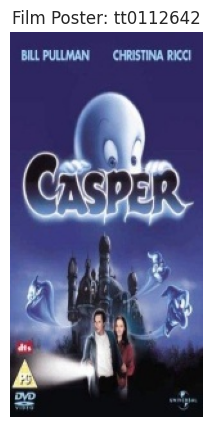

Overview: An afterlife therapist and his daughter meet a friendly young ghost when they move into a crumbling mansion in order to rid the premises of wicked spirits.
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 854ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 777ms/step
------------------------------
Model      Top Genres                Probabilities       
------------------------------
CNN        Drama                     0.4989
CNN        Comedy                    0.3973
CNN        Action                    0.3809
LSTM       Drama                     0.3708
LSTM       Action                    0.3477
LSTM       Adventure                 0.2890
------------------------------
Ground Truth Genres: Comedy, Family, Fantasy
------------------------------



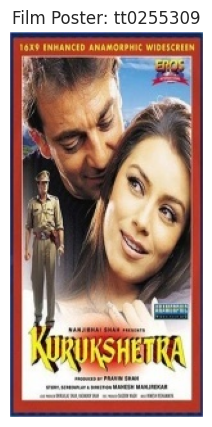

Overview: ACP Prithviraj is an honest cop. When he arrests the Chief Minister's son for assaulting a girl, the minister tries his best to create havoc in Prithviraj's life.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
------------------------------
Model      Top Genres                Probabilities       
------------------------------
CNN        Drama                     0.5584
CNN        Comedy                    0.5224
CNN        Romance                   0.4150
LSTM       Drama                     0.6095
LSTM       Comedy                    0.4707
LSTM       Romance                   0.2011
------------------------------
Ground Truth Genres: Action, Drama, Thriller
------------------------------



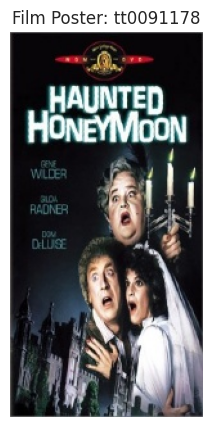

Overview: Two radio voice actors are getting married. Larry has fits of fear. A shrink needs 36 hours to scare him to death and cure him - a family reunion at a scary family castle.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
------------------------------
Model      Top Genres                Probabilities       
------------------------------
CNN        Drama                     0.4924
CNN        Action                    0.3840
CNN        Thriller                  0.3745
LSTM       Drama                     0.6593
LSTM       Comedy                    0.5176
LSTM       Romance                   0.2336
------------------------------
Ground Truth Genres: Comedy, Horror, Musical
------------------------------



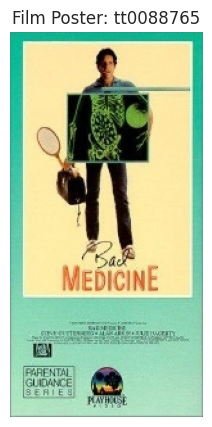

Overview: Jeff Marx wants to study medicine and become a physician. However, his grades are far from enough to get him into an American medical school. But instead he gets a chance to study medicine ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
------------------------------
Model      Top Genres                Probabilities       
------------------------------
CNN        Drama                     0.6345
CNN        Comedy                    0.4354
CNN        Romance                   0.4092
LSTM       Drama                     0.4727
LSTM       Comedy                    0.3716
LSTM       Action                    0.2563
------------------------------
Ground Truth Genres: Comedy
------------------------------



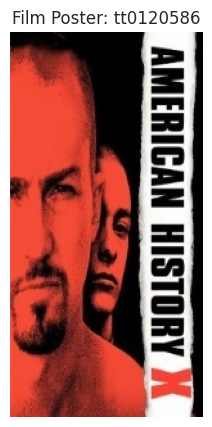

Overview: A former neo-nazi skinhead tries to prevent his younger brother from going down the same wrong path that he did.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
------------------------------
Model      Top Genres                Probabilities       
------------------------------
CNN        Drama                     0.6623
CNN        Action                    0.3712
CNN        Crime                     0.3701
LSTM       Drama                     0.6421
LSTM       Comedy                    0.4839
LSTM       Romance                   0.2266
------------------------------
Ground Truth Genres: Crime, Drama
------------------------------



In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import matplotlib.image as mpimg

# Load best weights for CNN and LSTM models
cnn_model.load_weights(checkpoint_cnn_filepath)
lstm_model.load_weights(checkpoint_lstm_filepath)

# Choose example films
example_film_indices = [2, 15, 33, 60, 88]
example_films = data_test.iloc[example_film_indices]

# Function to get top predictions and probabilities
def get_top_predictions(predictions, genres, num_predictions=3):
    top_indices = np.argsort(predictions)[-num_predictions:][::-1]
    top_genres = genres[top_indices]
    top_probs = predictions[top_indices]
    return top_genres, top_probs

# Loop through example films
for index, film in example_films.iterrows():
    film_id = film['Id']
    overview = film['Overview']
    ground_truth_genres = film[genres].to_numpy().astype(bool)
    ground_truth_genre_names = genres[ground_truth_genres]

    # Display film poster
    image_path = f"{img_loc}/{film_id}.jpg"
    img = mpimg.imread(image_path)
    plt.figure(figsize=(5, 5))
    plt.imshow(img)
    plt.title(f"Film Poster: {film_id}")
    plt.axis('off')
    plt.show()

    # Print overview
    print(f"Overview: {overview}")

    # Get CNN predictions
    image = tf.io.read_file(image_path)
    image = tf.io.decode_jpeg(image)
    cnn_input = tf.expand_dims(img_process(image, None)[0], axis=0)
    cnn_predictions = cnn_model.predict(cnn_input)[0]
    cnn_top_genres, cnn_top_probs = get_top_predictions(cnn_predictions, genres)

    # Get LSTM predictions
    lstm_input = tf.expand_dims(overview, axis=0)
    lstm_predictions = lstm_model.predict(lstm_input)[0]
    lstm_top_genres, lstm_top_probs = get_top_predictions(lstm_predictions, genres)

    # Display predictions in a table format
    print("-" * 30)
    print(f"{'Model':<10} {'Top Genres':<25} {'Probabilities':<20}")
    print("-" * 30)
    for i in range(len(cnn_top_genres)):
        print(f"{'CNN':<10} {cnn_top_genres[i]:<25} {cnn_top_probs[i]:.4f}")
    for i in range(len(lstm_top_genres)):
        print(f"{'LSTM':<10} {lstm_top_genres[i]:<25} {lstm_top_probs[i]:.4f}")
    print("-" * 30)
    print(f"Ground Truth Genres: {', '.join(ground_truth_genre_names)}")
    print("-" * 30 + "\n")